# Introduction

Fortunately, with libraries such as Scikit-Learn, it’s now easy to build and use almost any machine learning algorithm. But it’s helpful to have an idea of how a machine learning model works under the hood. This lets us diagnose the model when it’s underperforming or explain how it makes decisions, which is crucial if we want to convince others to trust our models.
In this assignment, we’ll look at how to build and use the Decision Tree and the Random Forest in Python. We’ll start by understanding how a single decision tree makes classifications on a simple problem. Then, we’ll work our way to using a random forest on a real-world data science problem.

# Dataset

The dataset we will use in this assignment is the Sonar dataset.

This is a dataset that describes sonar chirp returns bouncing off different surfaces. The 60 predictors are the strength of the returns at different angles. It is a binary classification problem that requires a model to differentiate rocks from metal cylinders. There are 208 observations.

It is a well-understood dataset. All of the variables are continuous and generally in the range of 0 to 1. The output variable is a string “M” for mine and “R” for rock, which will need to be converted to integers 1 and 0.

By predicting the class with the most observations in the dataset (M or mines) the Zero Rule Algorithm can achieve an accuracy of 53%.

You can learn more about this dataset at the UCI Machine Learning repository.
https://archive.ics.uci.edu/ml/datasets/Connectionist+Bench+(Sonar,+Mines+vs.+Rocks)

Download the dataset for free and place it in the "data" folder in your working directory with the filename sonar.all-data.csv.

# Set easy check

In [1]:
score = {}

# Import section

In [2]:
import random
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

np.random.seed(2020)
random.seed(2020)

In [3]:
from sklearn.model_selection import cross_val_score

# Preprocess data

Read data and convert targets to integers 1 and 0.

In [4]:
PATH = 'data/'
df = pd.read_csv(PATH+'sonar-all-data.csv', header=None)
df.columns = [f'feat_{col}' if col!=60 else 'target' for col in df.columns]
df['target'] = df['target'].map({'M': 1, 'R': 0})
df.head()

,feat_0,feat_1,feat_2,feat_3,feat_4,feat_5,feat_6,feat_7,feat_8,feat_9,...,feat_51,feat_52,feat_53,feat_54,feat_55,feat_56,feat_57,feat_58,feat_59,target
0,0.0200,0.0371,0.0428,0.0207,0.0954,0.0986,0.1539,0.1601,0.3109,0.2111,...,0.0027,0.0065,0.0159,0.0072,0.0167,0.0180,0.0084,0.0090,0.0032,0
1,0.0453,0.0523,0.0843,0.0689,0.1183,0.2583,0.2156,0.3481,0.3337,0.2872,...,0.0084,0.0089,0.0048,0.0094,0.0191,0.0140,0.0049,0.0052,0.0044,0
2,0.0262,0.0582,0.1099,0.1083,0.0974,0.2280,0.2431,0.3771,0.5598,0.6194,...,0.0232,0.0166,0.0095,0.0180,0.0244,0.0316,0.0164,0.0095,0.0078,0
3,0.0100,0.0171,0.0623,0.0205,0.0205,0.0368,0.1098,0.1276,0.0598,0.1264,...,0.0121,0.0036,0.0150,0.0085,0.0073,0.0050,0.0044,0.0040,0.0117,0
4,0.0762,0.0666,0.0481,0.0394,0.0590,0.0649,0.1209,0.2467,0.3564,0.4459,...,0.0031,0.0054,0.0105,0.0110,0.0015,0.0072,0.0048,0.0107,0.0094,0


# Split data (train and test)

In [5]:
X_train, X_test, y_train, y_test = train_test_split(df.drop(columns='target'), df['target'], test_size=0.2, random_state=2020)

# Cost functions

In this section you should implement two cost functions. Any of these can be used in the model.

## Gini index

In [6]:
def gini_index(x):
    """ Calculate Gini Index for a node
    Args:
        x: Numpy-array of targets in a node
    Returns:
        float: Gini index
    """    
    if len(x) == 0:
        return 0.0
    p = np.bincount(x) / len(x)
    return 1 - np.sum(p*p)

In [7]:
target = df['target'].values
gini_index(target)

0.4977348372781065

In [8]:
def gini_gain(parent_node, splits):
    """ Calculate Gini Gain for a particular split
    Args:
        parent_node: Numpy-array of targets in a parent node
        splits: List of two numpy-arrays. Each numpy-array is targets in a child node
    Returns:
        float: Gini gain
    """       
    splits_gini = np.sum([gini_index(split)*(len(split)/len(parent_node)) for split in splits])
    return gini_index(parent_node) - splits_gini

In [9]:
splits = [np.random.choice(df['target'].values, 100), np.random.choice(df['target'].values, 108)]
gini_gain(target, splits)

-0.0003705758273065962

## Entropy

In [10]:
def entropy(x):
    """ Calculate Entropy for a node
    Args:
        x: Numpy-array of targets in a node
    Returns:
        float: Entropy
    """
    if len(x) == 0:
        return 0.0
    p = np.clip(np.bincount(x) / len(x), 1e-15, 1.)
    return -np.sum(p * np.log(p))

In [11]:
def information_gain(parent_node, splits):
    """ Calculate Information Gain for a particular split
    Args:
        parent_node: Numpy-array of targets in a parent node
        splits: List of two numpy-arrays. Each numpy-array is targets in a child node
    Returns:
        float: Information Gain
    """     
    splits_entropy = np.sum([entropy(split)*(len(split)/len(parent_node)) for split in splits])
    return entropy(parent_node) - splits_entropy

# Split function

Implement split functions

In [12]:
def split(X, y, value):
    """ Split y-values in order to calculate gain later
    Args:
        X: 1-dimensional numpy-array of data predictor with shape (N,)
        y: 1-dimensional numpy-array of targets with shape (N,)
        value (float): the value by which the X should be splitted
    Returns:
        Two 1-dimensional numpy-arrays with targets related to splits
    """      
    left_mask = X < value
    right_mask = X >= value
    return y[left_mask], y[right_mask]


def split_dataset(X, y, column, value):
    """ Split dataset by a particular column and value
    Args:
        X: 2-dimensional numpy-array (N, num_feats). N-number of samples
        y: 1-dimensional numpy-array of targets with shape (N,)  
        column (int): the column by which the X should be splitted
        value (float): the value by which the column should be splitted
    Returns:
        Two 2-dimensional numpy-arrays with data and two 1-dimensional numpy-arrays with targets related to splits
        left_X, right_X, left_y, right_y
    """       
    left_mask = X[:, column] < value
    right_mask = X[:, column] >= value
    left_y, right_y = y[left_mask], y[right_mask]
    left_X, right_X = X[left_mask], X[right_mask]
    return left_X, right_X, left_y, right_y

# Decision tree

In [13]:
class Tree(object):
    """A decision tree classifier.

    Args:
        criterion : {"gini_gain", "information_gain"}
    """
    def __init__(self, criterion=None):
        self.impurity = None       
        self.threshold = None      
        self.column_index = None   
        self.outcome_probs = None  
        self.criterion = criterion 
        self.left_child = None     
        self.right_child = None    

    @property
    def is_terminal(self):
        """ Define is it terminal node
        """          
        return not bool(self.left_child and self.right_child)

    
    def _find_splits(self, X):
        """Find all possible split values."""
        split_values = set()

        # Get unique values in a sorted order
        x_unique = list(np.unique(X))
        for i in range(1, len(x_unique)):
            # Find a point between two values
            average = (x_unique[i - 1] + x_unique[i]) / 2.0
            split_values.add(average)

        return list(split_values)

    def _find_best_split(self, X, y, n_features):
        """Find best feature and value for a split. Greedy algorithm."""

        # Sample random subset of features
        subset = random.sample(list(range(0, X.shape[1])), n_features)
        max_gain, max_col, max_val = None, None, None

        for column in subset:
            split_values = self._find_splits(X[:, column])
            for value in split_values:
                splits = split(X[:, column], y, value)
                gain = self.criterion(y, splits)

                if (max_gain is None) or (gain > max_gain):
                    max_col, max_val, max_gain = column, value, gain
        return max_col, max_val, max_gain

    def fit(self, X, y, n_features=None, max_depth=None):
        """Fit model.

        Args:
            X (numpy-array): The training input samples. 2-dimensional numpy array.
            y (numpy-array): The target values. 1-dimensional numpy array.
            n_features (int): The number of features when fit is performed (default: all features)
            max_depth (int): The maximum depth of the tree. If None, then nodes are expanded until
                             all leaves are pure.
        """        
        try:
            # Exit from recursion using assert syntax
            if max_depth is not None:
                assert max_depth > 0
                max_depth -= 1

            if n_features is None:
                n_features = X.shape[1]

            column, value, gain = self._find_best_split(X, y, n_features)
            assert gain is not None

            self.column_index = column
            self.threshold = value
            self.impurity = gain

            # Split dataset
            left_X, right_X, left_target, right_target = split_dataset(X, y, column, value)

            # Grow left and right child
            self.left_child = Tree(self.criterion)
            self.left_child.fit(
                left_X, left_target, n_features, max_depth
            )

            self.right_child = Tree(self.criterion)
            self.right_child.fit(
                right_X, right_target, n_features, max_depth
            )
        except AssertionError:
            self.outcome_probs = np.around(np.sum(y) / y.shape[0])


    def predict_row(self, row):
        """Predict single row."""
        if not self.is_terminal:
            if row[self.column_index] < self.threshold:
                return self.left_child.predict_row(row)
            else:
                return self.right_child.predict_row(row)
        return self.outcome_probs

    def predict(self, X):
        """Make predictions.

        Args:
            X (numpy-array): The test input samples. 2-dimensional numpy array.
        """  
        result = np.zeros(X.shape[0])
        for i in range(X.shape[0]):
            result[i] = self.predict_row(X[i, :])
        return result

Fit two models with "max_depth=3" and "max_depth=None" hyperparameters. Explain the results.

In [14]:
model = Tree(criterion=gini_gain)
model.fit(X_train.values, y_train.values)
y_pred = model.predict(X_test.values)
print(f"Accuracy score is: {accuracy_score(y_test, y_pred)}")

Accuracy score is: 0.6666666666666666


In [15]:
model = Tree(criterion=gini_gain)
model.fit(X_train.values, y_train.values, max_depth=3)
y_pred = model.predict(X_test.values)
print(f"Accuracy score is: {accuracy_score(y_test, y_pred)}")

Accuracy score is: 0.6666666666666666


In [16]:
model = Tree(criterion=information_gain)
model.fit(X_train.values, y_train.values, max_depth=3)
y_pred = model.predict(X_test.values)
print(f"Accuracy score is: {accuracy_score(y_test, y_pred)}")

Accuracy score is: 0.7380952380952381


# Random forest

In [17]:
class RandomForestClassifier(object):
    """
    A random forest classifier.
    A random forest is a meta estimator that fits a number of decision tree
    classifiers on various sub-samples of the dataset and uses averaging to
    improve the predictive accuracy and control overfitting.
    
    Args:
        n_estimators : int, default=10
            The number of trees in the forest.

        max_depth : int, default=None
            The maximum depth of the tree. If None, then nodes are expanded until
            all leaves are pure.        

        n_features : int, default=None
            The number of features to consider when looking for the best split.
            If None, then `n_features=sqrt(n_features)`.

        criterion : {"gini", "entropy"}, default="gini"
            The function to measure the quality of a split. Supported criteria are
            "gini" for the Gini impurity and "entropy" for the information gain.
    """

    def __init__(self, n_estimators=10, max_depth=None, n_features=None, criterion="entropy", bootstrap=True):
        self.n_estimators = n_estimators
        self.max_depth = max_depth
        self.n_features = n_features
        self.bootstrap = bootstrap
        
        if criterion == "entropy":
            self.criterion = information_gain
        elif criterion == "gini":
            self.criterion = gini_gain
        else:
            raise ValueError(f"Unknown criterion '{criterion}'")
            
        self.trees = [Tree(criterion=self.criterion) for _ in range(n_estimators)]
        
    def _init_data(self, X, y):
        """Ensure data are in the expected format.
        Ensures X and y are stored as numpy ndarrays by converting from an
        array-like object if necessary. 
        Parameters
        Args:
            X : array-like
                Feature dataset.
            y : array-like, default=None
                Target values. By default is required, but if y_required = false
                then may be omitted.
        """
        self.size = len(X)
        
        if not isinstance(X, np.ndarray):
            self.X = np.array(X)
        else:
            self.X = X

        if not isinstance(y, np.ndarray):
            self.y = np.array(y)
        else:
            self.y = y
            
    def bootstrap_data(self, size):
        return np.random.randint(size, size=size)
    
    def fit(self, X, y):
        """Fit model.

        Args:
            X (numpy-array): The training input samples. 2-dimensional numpy array.
            y (numpy-array): The target values. 1-dimensional numpy array.
        """         
        if self.n_features is None:
            self.n_features = int(np.sqrt(X.shape[1]))
        elif X.shape[1] < self.n_features:
            raise ValueError(f"'n_features should be <= n_features'")
            
        self._init_data(X, y)
        
        for tree in self.trees:
            if self.bootstrap:
                idxs = self.bootstrap_data(self.size)
                X = self.X[idxs]
                y = self.y[idxs]
            else:
                X = self.X
                y = self.y
                
            tree.fit(
                X,
                y,
                n_features=self.n_features,
                max_depth=self.max_depth,
            )
            
    def predict(self, X):
        """Make predictions.

        Args:
            X (numpy-array): The test data input samples. 2-dimensional numpy array.
        """            
        if not isinstance(X, np.ndarray):
            X = np.array(X)

        if self.X is not None:
            predictions = np.zeros(len(X))
            for i in range(len(X)):
                row_pred = 0.
                for tree in self.trees:
                    row_pred += tree.predict_row(X[i, :])

                row_pred /= self.n_estimators
                predictions[i] = round(row_pred)
            return predictions  
        else:
            raise ValueError("You should fit a model before `predict`")

Fit two models with "n_estimators=10" and "n_estimators=100" hyperparameters. Explain the results.

In [18]:
model = RandomForestClassifier(n_estimators=10, max_depth=None, n_features=None, criterion="entropy")
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
print(f"Accuracy score is: {accuracy_score(y_test, y_pred)}")

Accuracy score is: 0.7380952380952381


In [19]:
model = RandomForestClassifier(n_estimators=100, max_depth=None, n_features=None, criterion="entropy")
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
print(f"Accuracy score is: {accuracy_score(y_test, y_pred)}")

Accuracy score is: 0.8809523809523809


Now it's your turn to explore the various parameters of sklearn [RandomForestClassifier](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html) and their influence on model quality.

# Homework part 1. RandomForestClassifier

_Note_: Consider **accuracy** as main metric of model performance on this dataset.

In [20]:
from sklearn.ensemble import RandomForestClassifier

**Task 1 (0.5 points)** Split the dataset into train, test and validation parts (0.6 / 0.2 / 0.2). First two will be used for model hyperparameter tuning whereas the best model quality should be evaluated on validation part.

In [21]:
# Add point to total score
score["Task_1"] = 0.5
# I think what done this task.

In [22]:
# Your code here
X, X_valid, y, y_valid = train_test_split(df.drop(columns='target'), df['target'], test_size=0.2, train_size=0.8, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, train_size =0.75, random_state=42)

In [23]:
# Check.
print("{0:7} {1:1}".format("df", df.shape[0]))            #100%
print("{0:7} {1:1}".format("X_train", X_train.shape[0]))  #~60%  208 * 0.60 = 124.8
print("{0:7} {1:1}".format("X_test", X_test.shape[0]))    #~20%  208 * 0.20 = 41.6
print("{0:7} {1:1}".format("X_valid", X_valid.shape[0]))  #~20%  208 * 0.20 = 41.6
#  All right!

df      208
X_train 124
X_test  42
X_valid 42


**Task 2 (2 points)**. Apply '_greedy_' hyperparameter tuning of RandomForestClassifier model. '_Greedy_' way means the following general approach. At first we tune one model parameter whereas others are fixed with default values. Then we move on to tune the second parameter whereas others are fixed default values and first has the best values from previous step. After it we tune the third parameter with best fixed values for previous two and default values for the rest. Repeat until we go through all the parameters, then repeat this cycle if you are seeing a clear increase in the test metric. <br>

Although this approach has a lot of disadvantages (you may think which ones), sometimes that is the only way to tune model typerparams due to big training time **if you understand how the model parameters are interrelated and the tuning order takes those dependencies into account.**<br>

Here is one of the possible options for RandomForestClassifier:
- Choose a decent value for number of trees using '_elbow_' rule. You may plot the dependence of **accuracy** on trees_num and pick up the number after which the error decreases not **as much as before**. 
- Pick up the best split criterion ('gini' / 'entropy') and then tune _max_depth_, _min_samples_split_, _min_samples_leaf_.
- Increase number of trees with best found parameters so far.
- Repeat this excersice starting from picking the best split criterion while other params are fixed with best values from previous steps **if you observe a significant test metric improvement**. Otherwise just stop and measure your best model result on validation set.

***Scroll down to brutefoce function***

In [25]:
# Add point to total score
score["Task_2"] = 2

# I think what done this task.

In [26]:
# Import a libraries for plotting and set seaborn
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme(style="darkgrid")

In [27]:
# Create function elbow plotting
def plotting(accur, second_parameter : str, value):
    ''' 
    Create plot for two hyperparameters.
    '''
    fmri = pd.DataFrame({"accur" : accur, 
                         second_parameter : value})
    scatter = sns.lineplot(x=second_parameter, y="accur",
                 data=fmri, legend= True);

In [28]:
# Find optimal hyperparameter:
def find_hp_best_value(hyp_par, set_range, plot=False): # start=10, final=500, step=10,
    top = 0
    accur = []
    values_save = []
    best_value = 0
    
    for value in set_range:
        hp[hyp_par] = value
        RFC =  RandomForestClassifier(n_estimators=hp["n_estimators"], 
                                      criterion=hp["criterion"], 
                                      max_depth=hp["max_depth"],
                                      min_samples_split=hp["min_samples_split"],
                                      min_samples_leaf=hp["min_samples_leaf"],
                                      n_jobs=16,
                                      random_state=42 )
        RFC.fit(X_train, y_train)
        y_pred = RFC.predict(X_test)

        accur.append(accuracy_score(y_test, y_pred))
        values_save.append(value)

        if top < max(accur):
            top = max(accur)
            best_value = value
    
    if plot:
        plotting(accur, hyp_par, values_save)
    
    hp[hyp_par] = best_value
    return best_value

In [29]:
# I create the tool hp_table, it present dictionary "hp" like table
def dict_to_table(dictionary):
    return pd.DataFrame.from_dict(dictionary, orient='index', columns="Value".split())

In [30]:
# I create the dictionary for save best hyperparameters(hp), 
# but for first iteration set input default value.
    
hp = {'accuracy': 0.1, 
      'n_estimators': 100, 
      'criterion': 'gini', 
      'max_depth': None, 
      'min_samples_split': 2,  
      'min_samples_leaf': 1,
      'n_jobs':14}

Number of operation:  1
Number of operation:  2


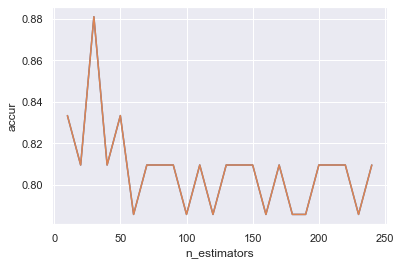

In [31]:
# This is automatical search best hyperparameters.
# if you need see elbow plot, please reset hp dictionary and start find_hp_best_value() 
# in another cell with plot=(true)

def bruteforce():
 
    old_hp = {}
    num_oper = 1

    while old_hp != hp:
        print("Number of operation: ", num_oper)
        old_hp = hp.copy()
        find_hp_best_value("n_estimators", np.arange(10, 250, 10), plot=True)
        find_hp_best_value("criterion", ["gini", "entropy"], plot=False)
        find_hp_best_value("max_depth", np.arange(1, 15, 1), plot=False)
        find_hp_best_value("min_samples_split", np.arange(2, 15, 1), plot=False)
        find_hp_best_value("min_samples_leaf", np.arange(1, 10, 1), plot=False)
        num_oper +=1

bruteforce()

In [32]:
dict_to_table(hp)

,Value
accuracy,0.1
n_estimators,30
criterion,gini
max_depth,9
min_samples_split,2
min_samples_leaf,1
n_jobs,14


Test and find estimator on valid part data

In [33]:
best_bf = RandomForestClassifier(n_estimators=hp["n_estimators"],  
                                  criterion=hp["criterion"], 
                                  max_depth=hp["max_depth"],
                                  min_samples_split=hp["min_samples_split"],
                                  min_samples_leaf=hp["min_samples_leaf"],
                                  n_jobs=14,
                                  random_state=42 )


In [34]:
best_bf.fit(X_train, y_train)
print("Accuracy sore on test part:", accuracy_score(y_test, best_bf.predict(X_test)))

Accuracy sore on test part: 0.8809523809523809


In [35]:
cross_val_score(best_bf, X, y, cv=5).mean()

0.8014260249554368

In [36]:
best_bf.fit(X, y)

RandomForestClassifier(max_depth=9, n_estimators=30, n_jobs=14, random_state=42)

In [37]:
bf_valid_acc = accuracy_score(y_valid, best_bf.predict(X_valid))
bf_valid_acc

0.8333333333333334

### Grid Search and Random Search

If you have enough computational power for model training in a reasonable amount of time more sophisticated approach of hyperparameter tuning would be either Grid Search or Random Search.<br>

In a nutshell Grid Search allows you to pass through all different combinations of given model parameters and their values and choose the best combination. Whereas Random Search would randomly choose values for given model parameters and evaluate them on test data untill it reaches the specified number of iterations.<br>

More information here [Gentle introduction to Grid and Random search](https://medium.com/@senapati.dipak97/grid-search-vs-random-search-d34c92946318) and here [Detailed Explanation with code examples](https://machinelearningmastery.com/hyperparameter-optimization-with-random-search-and-grid-search/).

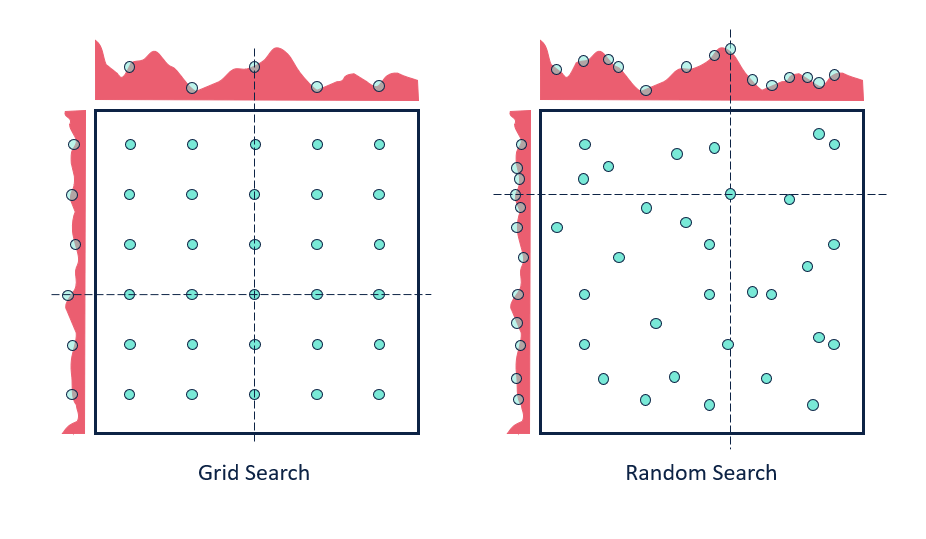

**Task 3 (1 point)**. Compare your previous results with [GridSearch](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html) hyperparameter tuning. You may tune best hyperparameters for forest with several trees and then increase it while measure the quality on validation dataset.

In [38]:
# Add point to total score
score["Task_3"] = 1

# I think what done this task.

In [39]:
# Import a GridSearchCV and RandomizedSearchCV
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV

In [40]:
# I narrowed down dispersion values to save time, 
# but if save old values result not change. 
rfc_param_grid = {'n_estimators': np.arange(10,250,10),
                  'criterion': ['gini',"entropy"],
                  'max_depth': np.arange(1,15,1),
                  'min_samples_split': np.arange(2,10,1),
                  'min_samples_leaf': np.arange(1,10,1)}

In [41]:
# Your code here


                                
rfc_gs_clf = GridSearchCV(RandomForestClassifier(random_state=42), 
                       rfc_param_grid, 
                       pre_dispatch='2*n_jobs', 
                       n_jobs=14,
                       cv=3,
                       scoring='accuracy') #add scuracy

In [42]:
rfc_gs_clf.fit(X, y)

GridSearchCV(cv=3, estimator=RandomForestClassifier(random_state=42), n_jobs=14,
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14]),
                         'min_samples_leaf': array([1, 2, 3, 4, 5, 6, 7, 8, 9]),
                         'min_samples_split': array([2, 3, 4, 5, 6, 7, 8, 9]),
                         'n_estimators': array([ 10,  20,  30,  40,  50,  60,  70,  80,  90, 100, 110, 120, 130,
       140, 150, 160, 170, 180, 190, 200, 210, 220, 230, 240])},
             scoring='accuracy')

In [43]:
rfc_gs_best_params = rfc_gs_clf.best_params_
dict_to_table(rfc_gs_best_params)

,Value
criterion,gini
max_depth,7
min_samples_leaf,2
min_samples_split,6
n_estimators,20


In [44]:
grid_search_acc = accuracy_score(y_valid, rfc_gs_clf.predict(X_valid))
grid_search_acc

0.8095238095238095

**Task 4 (1 point)**. And finally tune forest hyperparameters with [RandomSearch](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.RandomizedSearchCV.html). Compare results to previous attempts.

In [45]:
# Add point to total score
score["Task_4"] = 1

# I think what done this task.

In [46]:
rcf_rs_clf = RandomizedSearchCV(RandomForestClassifier(random_state=42), 
                             rfc_param_grid,
                             n_iter=12,
                             scoring='accuracy',
                             pre_dispatch='2*n_jobs', 
                             n_jobs=14,
                             cv=3,
                             random_state=42)

In [47]:
rcf_rs_clf.fit(X, y);

In [48]:
dict_to_table(rcf_rs_clf.best_params_)

,Value
n_estimators,160
min_samples_split,5
min_samples_leaf,3
max_depth,10
criterion,gini


In [49]:
random_search_acc = accuracy_score(y_valid, rcf_rs_clf.predict(X_valid))
random_search_acc

0.8095238095238095

In [50]:
# Compare results to previous attempts.
print("Accuracy from BruteForce search: ", bf_valid_acc)
print("Accuracy from GridSearch:        ", grid_search_acc)
print("Accuracy from RandomSearch:      ", random_search_acc)


Accuracy from BruteForce search:  0.8333333333333334
Accuracy from GridSearch:         0.8095238095238095
Accuracy from RandomSearch:       0.8095238095238095


**Task 5 (0.5 points)**. Tell us about your experience in hyperparameter tuning with the approaches above. What do you think would be the best option for this task and why?

In [51]:
score["Task_5"] = 0.5

<!-- Your cool ideas here... -->
It's very cool experience.

I make table for observation, on this set and this parameter:

| optimiser           | Accuracy           | operation time     |
|   ---               | :---:              |:---:               |
|BruteForce           | 0.8333333333333334 |   few minute       |
|GridSearchCV  | 0.8095238095238095 |   ~ 0.5 hour         |
|RandomSearchCV  | 0.8095238095238095 |   few seconds      |

We see GridSearch and RandomSearch give our equal accuracy, but operation time very different. In this case between this guys I choose RandomSearch. 

If I provide equal list hyperparameters for three model optimiser, bruteforce - best give me best accuracy and middle cost time!

After test, my bruteforce model present the best result of all ressults. Results of GridSearchCV and RandomSearchCV to equal, but less than bruteforce.

"Greedy" method after coding and execute return result  in less than 10 minutes, GridSearchCV search work more than 30 min, and RandomSearch work few seconds.

On this task I choice bruteforce approach, the size this dataset is little and if compare accuracy, brute force achieve great result and cost less times. I understand, this timing bind with many the hyperparameters who I give this optimizers.

But grid and random search many take comfortable to use.

---

### Desicion tree explained

Remember the [Titanic](https://www.kaggle.com/c/titanic) competition from last week? Wouldn't be a good idea to visualize one of possible desicion-making processes of _survived_ / _dead_ labeling?

**Task 6 (1 point)**. Load titanic dataset, split it into train/test parts, apply simple hyperparameter tuning of [DesicionTreeClassifier](https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html) (use one of the approaches above) in order to have **test accuracy more than 0.65**. <br>

Draw the best tree decision making process. You may use [sklearn.tree.prot_tree](https://scikit-learn.org/stable/modules/generated/sklearn.tree.plot_tree.html).<br>

In [52]:
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree
import matplotlib.pyplot as plt
# your code here

In [53]:
# load titanic data
import os
PATH = "./data/"
data = pd.read_csv(os.path.join(PATH, 'titanic', 'train.csv')).set_index('PassengerId')
test = pd.read_csv(os.path.join(PATH, 'titanic', 'test.csv'))

In [54]:
data.head(2)

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,,
1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C


In [55]:
data['male'] = data['Sex'].map({'male': 1,'female': 0})
data['female'] = data['Sex'].map({'male': 0,'female': 1})
data['Cabin_have'] = data['Cabin'].map(lambda x: 1  if type(x) == "str" else 0 )
data['Age'] = data['Age'].fillna(data['Age'].median())

In [56]:

test['male'] = test['Sex'].map({'male': 1,'female': 0})
test['female'] = test['Sex'].map({'male': 0,'female': 1})
test['Cabin_have'] = test['Cabin'].map(lambda x: 1  if type(x) == "str" else 0 )
test['Age'] = test['Age'].fillna(test['Age'].median())

In [57]:
min_feat = ["Pclass", "male", "female" ]
features = ["Pclass", "male", "female", "SibSp", "Fare", "Age", 'Cabin_have']

features = min_feat

X = data[features]
y = data['Survived']

X_train_t,  X_test_t, y_train_t, y_test_t = train_test_split(X, y, test_size=0.3, 
                                                           random_state=42)

In [58]:
model = DecisionTreeClassifier(criterion="gini", 
                               max_depth=None,
                               max_features=None,
                               random_state=42 )

In [59]:
model.fit(X_train_t, y_train_t)

DecisionTreeClassifier(random_state=42)

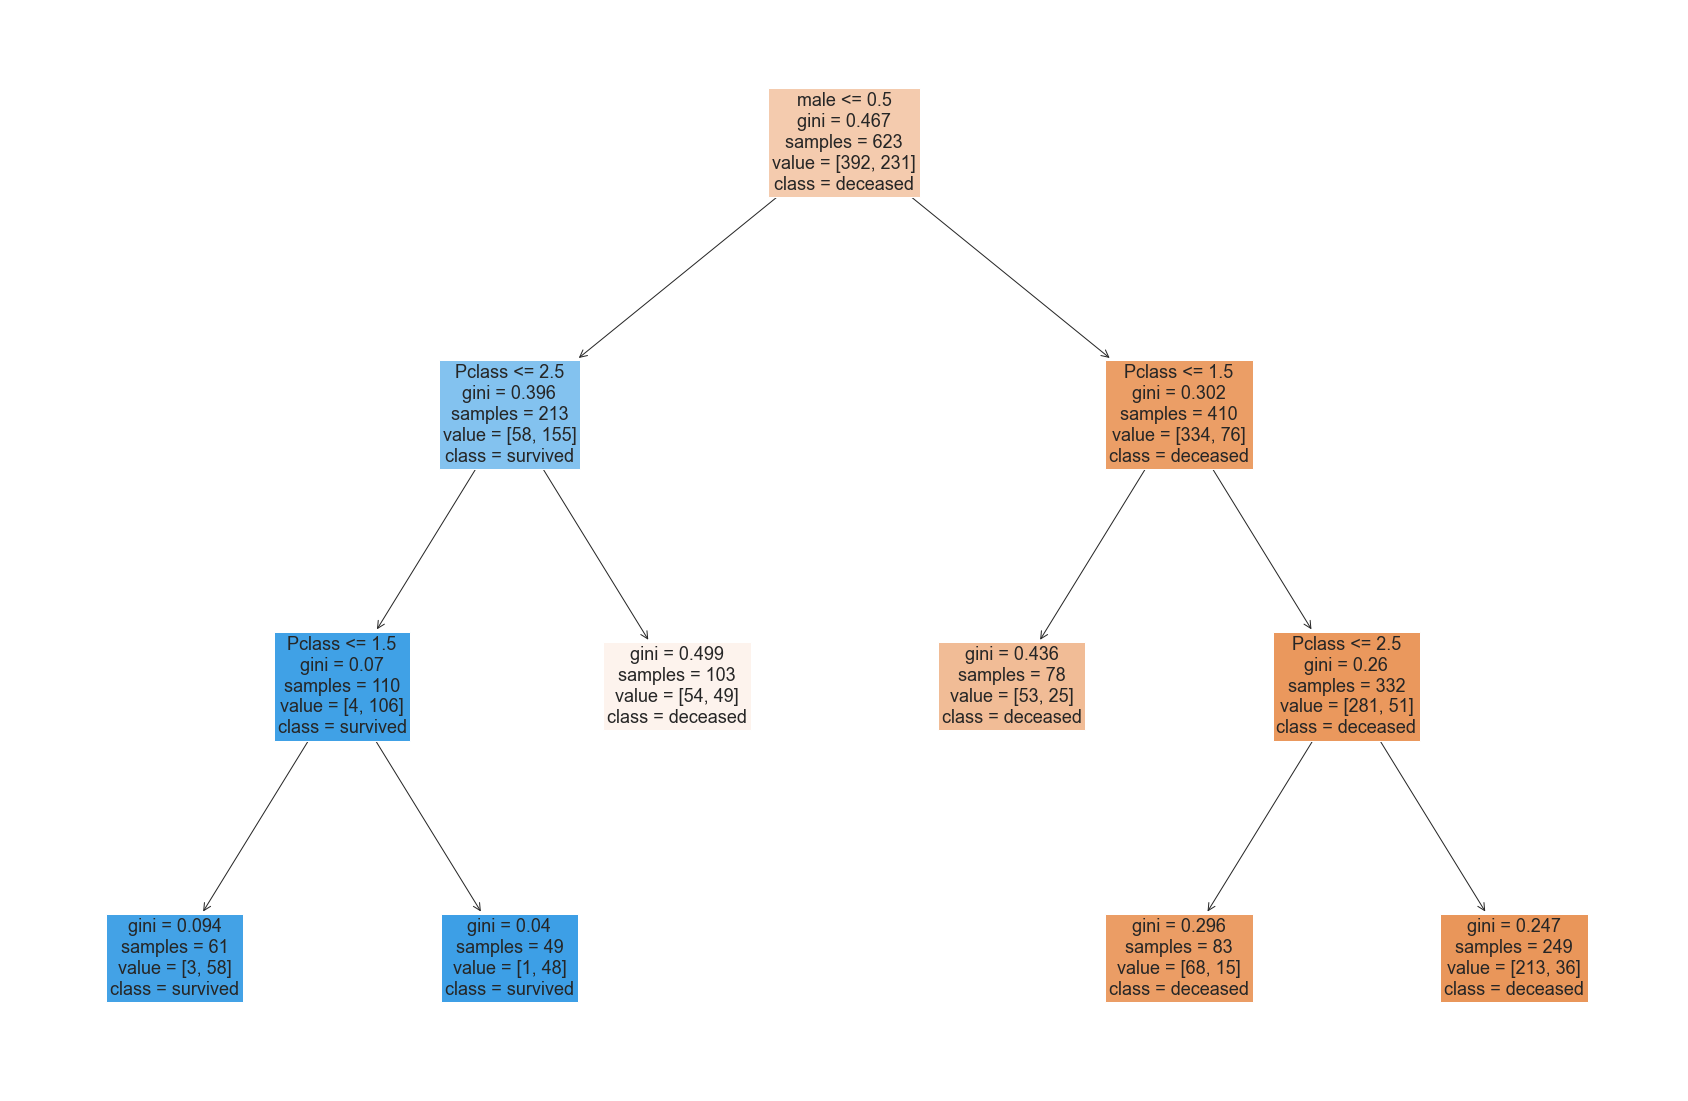

In [60]:
plt.figure(figsize=(30,20))
tree.plot_tree(model, filled=True, fontsize=18, feature_names=X_train_t.columns, \
          class_names=['deceased', 'survived'])
plt.show()

In [61]:

train_predict = model.predict(X_train_t)

train_predict_cv = cross_val_score(model, X_train_t, y_train_t,
                      scoring='accuracy', cv=5).mean()
print("CV on X_train: ", train_predict_cv)

CV on X_train:  0.7833290322580646


In [62]:

test_predict = model.predict(X_test_t)

test_predict_cv = cross_val_score(model, X_test_t, y_test_t,
                      scoring='accuracy', cv=5).mean()
print("CV on test:                 ", test_predict_cv)
print("Accuracy on test without CV:", accuracy_score(y_valid, rcf_rs_clf.predict(X_valid)))

CV on test:                  0.791194968553459
Accuracy on test without CV: 0.8095238095238095


___Is it easy to interpret its results?___

Not! In first time interpret it's hard. I think need more time and examples works with trees so that to understand what it means. 

___Are you able to explain to a random person why would he survive / die on the titanic?___

In homework "Titanic" I explain my thinks thread. I think yes, I able to explain why would he survive / die on the titanic.

In [63]:
# Test accuracy more to 0.65
score["Task_6"] = 1

# Homework part 2. RandomForestRegressor

**Task 7 (2 points)**. Write your own ___DecisionTreeRegressor___ class with _MSE_ split criterion and settable parameter *max_depth*. Demonstrate its consistency on the proposed artificial data (or some other) by comparing MSE of train predictions with [sklearn.tree.DecisionTreeRegressor](https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeRegressor.html). <br>

Provide examples for different _max_depth_ parameter.

Of course you may re-use code for *DecisionTreeClassifier*. You need to figure out what needs to be changed in it for Classification -> Regression transformation.<br>

**! You are allowed to use only NumPy library** in this assigment.

In [64]:
import numpy as np

def f(X):
    return X[:, 0]**3 + np.log(np.exp(X[:, 1]) + np.exp(X[:, 2])) + np.sqrt(abs(X[:, 3])) * X[:, 4]

n_samples = 100

stdv = 1. / np.sqrt(5)

X = np.random.uniform(-stdv, stdv, size = (n_samples, 5))
y = f(X)

In [65]:
def mse_calc(data):
    actual_values = data[:]
    if len(actual_values) == 0:
         mse = 0
    else:
        prediction = np.mean(actual_values)

        mse = ((actual_values - prediction) ** 2).mean() 
        
    return mse

def mse_gain(parent_node, splits):
    
    splits_mse = np.sum([mse_calc(split)*(len(split)/len(parent_node)) for split in splits])

    return splits_mse

In [66]:
# Your code here
class TreeRegressor(object):
    """
    A decision tree regressor.
    Decision Trees (DTs) are a non-parametric supervised learning method used for classification and 
    regression. The goal is to create a model that predicts the value of a target variable by learning 
    simple decision rules inferred from the data features. 
    A tree can be seen as a piecewise constant approximation.
    
    Args:

        max_depth : int, default=None
            The maximum depth of the tree. If None, then nodes are expanded until
            all leaves are pure.        

        criterion : {"mse"} default="mse"
              The function to measure the quality of a split.
    """
    
    def __init__(self, max_depth=None, criterion=mse_gain, random_state=None):
        self.impurity = None       
        self.threshold = None      
        self.column_index = None   
        self.outcome_probs = None  
        self.criterion=criterion
        self.left_child = None     
        self.right_child = None    
        self.max_depth = max_depth
        self.random_state=np.random.RandomState(random_state)

    @property
    def is_terminal(self):
        """ Define is it terminal node
        """
        return not bool(self.left_child and self.right_child)
    
    
    def _find_splits(self, X):
        """Find all possible split values."""
        split_values = set()

        # Get unique values in a sorted order
        x_unique = list(np.unique(X))
        
        for i in range(1, len(x_unique)):
            # Find a point between two values
            average = (x_unique[i - 1] + x_unique[i]) / 2.0
            split_values.add(average)

        return list(split_values)

    def _find_best_split(self, X, y, n_features):
        """Find best feature and value for a split. Greedy algorithm."""

        # Sample random subset of features
        subset = random.sample(list(range(0, X.shape[1])), n_features)
        max_gain, max_col, max_val = None, None, None

        for column in subset:
            
            split_values = self._find_splits(X[:, column])
            for value in split_values:
                splits = split(X[:, column], y, value)
                gain = self.criterion(y, splits)

                if (max_gain is None) or (gain < max_gain):
                    max_col, max_val, max_gain = column, value, gain
        return max_col, max_val, max_gain

    
    
    def fit(self, X, y, n_features=None, max_depth=None):
        """Fit model.

        Args:
            X (numpy-array): The training input samples. 2-dimensional numpy array.
            y (numpy-array): The target values. 1-dimensional numpy array.
            n_features (int): The number of features when fit is performed (default: all features)
            max_depth (int): The maximum depth of the tree. If None, then nodes are expanded until
                             all leaves are pure.
        """        
        try:
            # Exit from recursion using assert syntax
            if max_depth is not None:
                assert max_depth > 0
                max_depth -= 1

            if n_features is None:
                n_features = X.shape[1]

            column, value, gain = self._find_best_split(X, y, n_features)
            assert gain is not None

            self.column_index = column
            self.threshold = value
            self.impurity = gain

            # Split dataset
            left_X, right_X, left_target, right_target = split_dataset(X, y, column, value)

            # Grow left and right child
            self.left_child = TreeRegressor(self.criterion)
            self.left_child.fit(
                left_X, left_target, n_features, max_depth
            )

            self.right_child = TreeRegressor(self.criterion)
            self.right_child.fit(
                right_X, right_target, n_features, max_depth
            )
        except AssertionError:
            self.outcome_probs =  np.mean(y) 


    def predict_row(self, row):
        """Predict single row."""
        if not self.is_terminal:
            if row[self.column_index] < self.threshold:
                return self.left_child.predict_row(row)
            else:
                return self.right_child.predict_row(row)
        return self.outcome_probs

    def predict(self, X):
        """Make predictions.

        Args:
            X (numpy-array): The test input samples. 2-dimensional numpy array.
        """  
        result = np.zeros(X.shape[0])
        for i in range(X.shape[0]):
            result[i] = self.predict_row(X[i, :])
        return result

In [67]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

### Test

In [68]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error

In [69]:
table_mse_tree = {}

for md in np.arange(0,30):
    
    my_reg = TreeRegressor(max_depth = md or None, random_state=42)
    my_reg.fit(X_train, y_train)
    my_reg_mse = mean_squared_error(y_test, my_reg.predict(X_test))

    sk_reg = DecisionTreeRegressor(max_depth = md or None, random_state=42)
    sk_reg.fit(X_train, y_train)
    sk_reg_mse = mean_squared_error(y_test, sk_reg.predict(X_test))
    
    table_mse_tree[md] = [my_reg_mse, sk_reg_mse, my_reg_mse - sk_reg_mse]

In [70]:
print("How different MSE between my TreeRegressor and Sklearn DecisionTreeRegressor")
pd.DataFrame.from_dict(table_mse_tree, orient='index',columns=["my", "sklearn", "diff_value"])

How different MSE between my TreeRegressor and Sklearn DecisionTreeRegressor


,my,sklearn,diff_value
0,0.016529,0.016882,-0.000353
1,0.017257,0.036776,-0.019519
2,0.015689,0.025392,-0.009703
3,0.018633,0.013875,0.004758
4,0.016808,0.018046,-0.001238
5,0.014550,0.016170,-0.001620
6,0.014934,0.015203,-0.000269
7,0.017012,0.017227,-0.000216
8,0.015761,0.015862,-0.000102
9,0.019406,0.015033,0.004374


### _Notes:_

___I'm happy, my model it's work! I observation diff between model mse, but my model much simple.___ Before estimate this task, freshing in your memory criterions from lecture: https://youtu.be/GJX70lNnkjw?t=2522

In [71]:
score["Task_7"] = 2

---

**Task 8 (2 points)**. Write your own ___RandomForestRegressor___ class with MSE split criterion and settable parameter _max_depth_.  Demonstrate its consistency on the proposed artificial data (or some other) by comparing MSE of train predictions with [sklearn.ensemble.RandomForestRegressor](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestRegressor.html).<br>

Provide examples for different max_depth parameter.<br>

**! You are allowed to use only NumPy library** in this assigment.

In [72]:
class ForestRegressor(object):
    """
    A random forest regressor.
    
    """

    def __init__(self, n_estimators=100, 
                 max_depth=None, 
                 n_features=None, 
                 criterion=mse_gain, 
                 bootstrap=False,
                 random_state=None):
        
        self.n_estimators = n_estimators
        self.max_depth = max_depth
        self.n_features = n_features
        self.bootstrap = bootstrap
        self.criterion = criterion
        self.random_state=np.random.RandomState(random_state)
            
        self.trees = [TreeRegressor(criterion=self.criterion) for _ in range(n_estimators)]
        
    def _init_data(self, X, y):
        """Ensure data are in the expected format.
        Ensures X and y are stored as numpy ndarrays by converting from an
        array-like object if necessary. 
        Parameters
        Args:
            X : array-like
                Feature dataset.
            y : array-like, default=None
                Target values. By default is required, but if y_required = false
                then may be omitted.
        """
        self.size = len(X)
        
        if not isinstance(X, np.ndarray):
            self.X = np.array(X)
        else:
            self.X = X

        if not isinstance(y, np.ndarray):
            self.y = np.array(y)
        else:
            self.y = y
            
    def bootstrap_data(self, size):
        return np.random.randint(size, size=size)
    
    def fit(self, X, y):
        """Fit model.

        Args:
            X (numpy-array): The training input samples. 2-dimensional numpy array.
            y (numpy-array): The target values. 1-dimensional numpy array.
        """         
        if self.n_features is None:
            self.n_features = X.shape[1]
        elif X.shape[1] < self.n_features:
            raise ValueError(f"'n_features should be <= n_features'")
            
        self._init_data(X, y)
        
        for tree in self.trees:
            if self.bootstrap:
                idxs = self.bootstrap_data(self.size)
                X = self.X[idxs]
                y = self.y[idxs]
            else:
                X = self.X
                y = self.y
                
            tree.fit(
                X,
                y,
                n_features=self.n_features,
                max_depth=self.max_depth,
            )
            
    def predict(self, X):
        """Make predictions.

        Args:
            X (numpy-array): The test data input samples. 2-dimensional numpy array.
        """            
        if not isinstance(X, np.ndarray):
            X = np.array(X)

        if self.X is not None:
            predictions = np.zeros(len(X))
            for i in range(len(X)):
                row_pred = 0.
                for tree in self.trees:
                    row_pred += tree.predict_row(X[i, :])

                row_pred /= self.n_estimators

                predictions[i] =row_pred
            return predictions 
        else:
            raise ValueError("You should fit a model before `predict`")

### Test ForestRegressor

In [73]:
from sklearn.ensemble import RandomForestRegressor

In [74]:
my_reg = ForestRegressor(max_depth = 10, bootstrap=False)
my_reg.fit(X_train, y_train)
my_reg_mse = mean_squared_error(y_test, my_reg.predict(X_test))
my_reg_mse 

0.014631156696932086

In [75]:
sk_reg = RandomForestRegressor(max_depth = 10 or None, bootstrap=False, random_state=42, n_jobs=8)
sk_reg.fit(X_train, y_train)
sk_reg_mse = mean_squared_error(y_test, sk_reg.predict(X_test))
sk_reg_mse

0.014941451706994036

In [76]:
table_mse_forest = {}

for md in np.arange(0,10,1):
    
    my_reg = ForestRegressor(max_depth = md or None, bootstrap=False)
    my_reg.fit(X_train, y_train)
    my_reg_mse = mean_squared_error(y_test, my_reg.predict(X_test))

    sk_reg = RandomForestRegressor(max_depth = md or None, bootstrap=False, random_state=42, n_jobs=8)
    sk_reg.fit(X_train, y_train)
    sk_reg_mse = mean_squared_error(y_test, sk_reg.predict(X_test))
    
    table_mse_forest[md] = [my_reg_mse, sk_reg_mse, my_reg_mse - sk_reg_mse]

In [77]:
print("How different MSE between my ForestRegressor and Sklearn RandomForestRegressor")
pd.DataFrame.from_dict(table_mse_forest, orient='index',columns=["my", "sklearn", "diff_value"])

How different MSE between my ForestRegressor and Sklearn RandomForestRegressor


,my,sklearn,diff_value
0,0.014265,0.014984,-0.000719
1,0.036776,0.036776,0.000000
2,0.025392,0.025392,0.000000
3,0.013875,0.013875,0.000000
4,0.016809,0.016875,-0.000066
5,0.014715,0.015258,-0.000542
6,0.014083,0.014314,-0.000231
7,0.013992,0.014675,-0.000683
8,0.014725,0.015146,-0.000420
9,0.014653,0.014997,-0.000344


In [78]:
# Model is work.

score["Task_8"] = 2

# Homework part 3 (bonus). Speeding up forest training process

**Task 9 (3 points)** Devise a way to speed up training against the default version of our custom _RandomForestClassifier_ or your own _RandomForestRegressor_. You may want use [`joblib`](https://joblib.readthedocs.io/en/latest/) for parallelizing trees training. Provide graphs of time dependences on the number of trees in your _fast_ version with different number of cores / threads used against default one.

In [79]:
# Your code here

In [80]:
from joblib import parallel_backend, Parallel, delayed
from multiprocessing import Pool
import os
import time

In [81]:
class TreeRegressorV8(object):
    """
    A decision tree regressor.
    Decision Trees (DTs) are a non-parametric supervised learning method used for classification and 
    regression. The goal is to create a model that predicts the value of a target variable by learning 
    simple decision rules inferred from the data features. 
    A tree can be seen as a piecewise constant approximation.
    
    Args:

        max_depth : int, default=None
            The maximum depth of the tree. If None, then nodes are expanded until
            all leaves are pure.        

        criterion : {"mse"} default="mse"
              The function to measure the quality of a split.
    """
    
    def __init__(self, max_depth=None, criterion=mse_gain, random_state=None, n_jobs=-1):
        self.impurity = None       
        self.threshold = None      
        self.column_index = None   
        self.outcome_probs = None  
        self.criterion=criterion
        self.left_child = None     
        self.right_child = None    
        self.max_depth = max_depth
        self.random_state=np.random.RandomState(random_state)
        self.n_jobs = n_jobs

    @property
    def is_terminal(self):
        """ Define is it terminal node
        """
        return not bool(self.left_child and self.right_child)
    
    
    def _find_splits(self, X):
        """Find all possible split values."""
        split_values = set()

        # Get unique values in a sorted order
        x_unique = list(np.unique(X))
        
        def splitting(iter):
            average = (x_unique[iter - 1] + x_unique[iter]) / 2.0
            split_values.add(average)
        
        # SPEED UP
        Parallel(n_jobs=self.n_jobs)(delayed(splitting)(i) for i in range(1, len(x_unique)))

        return list(split_values)

    def _find_best_split(self, X, y, n_features):
        """Find best feature and value for a split. Greedy algorithm."""

        # Sample random subset of features
        subset = random.sample(list(range(0, X.shape[1])), n_features)
        max_gain, max_col, max_val = None, None, None

        for column in subset:
            
            split_values = self._find_splits(X[:, column])
            
            def gain_check(value):
                splits = split(X[:, column], y, value)
                gain = self.criterion(y, splits)

                if (max_gain is None) or (gain < max_gain):
                    max_col, max_val, max_gain = column, value, gain

            Parallel(n_jobs=self.n_jobs)(delayed(gain_check)(value) for value in split_values)
        
        return max_col, max_val, max_gain

    
    
    def fit(self, X, y, n_features=None, max_depth=None):
        """Fit model.

        Args:
            X (numpy-array): The training input samples. 2-dimensional numpy array.
            y (numpy-array): The target values. 1-dimensional numpy array.
            n_features (int): The number of features when fit is performed (default: all features)
            max_depth (int): The maximum depth of the tree. If None, then nodes are expanded until
                             all leaves are pure.
        """        
        try:
            # Exit from recursion using assert syntax
            if max_depth is not None:
                assert max_depth > 0
                max_depth -= 1

            if n_features is None:
                n_features = X.shape[1]

            column, value, gain = self._find_best_split(X, y, n_features)
            assert gain is not None

            self.column_index = column
            self.threshold = value
            self.impurity = gain

            # Split dataset
            left_X, right_X, left_target, right_target = split_dataset(X, y, column, value)

            # Grow left and right child
            self.left_child = TreeRegressorV8(self.criterion)
            self.left_child.fit(
                left_X, left_target, n_features, max_depth
            )

            self.right_child = TreeRegressorV8(self.criterion)
            self.right_child.fit(
                right_X, right_target, n_features, max_depth
            )
        except AssertionError:
            self.outcome_probs =  np.mean(y)


    def predict_row(self, row):
        """Predict single row."""
        if not self.is_terminal:
            if row[self.column_index] < self.threshold:
                return self.left_child.predict_row(row)
            else:
                return self.right_child.predict_row(row)
        return self.outcome_probs

    def predict(self, X):
        """Make predictions.

        Args:
            X (numpy-array): The test input samples. 2-dimensional numpy array.
        """  
        result = np.zeros(X.shape[0])
        def res(i): 
            result[i] = self.predict_row(X[i, :])
        
        Parallel(n_jobs=self.n_jobs)(delayed(res)(i) for i in range(X.shape[0]))
        
        workers_number = self.n_jobs


        def main():
            tasks = list(range(X.shape[0]))

            start_time = time.perf_counter()

            # Уход в паралельные вычисления:
            with Pool(workers_number) as pool_of_processes:
                answers = list(pool_of_processes.map(res, tasks))

            # Всё, тут мы вышли из режима многозадачности. Работает один родительский процесс.
            finish_time = time.perf_counter()
            print("Duration:", finish_time - start_time)

            print(*answers)
    
        if __name__ == '__main__':
            main()
        
        return result

In [82]:
# Define function for measure time execution
def time_test(reg):
    start_time = time.perf_counter()
    
    reg.fit(X_train, y_train)
    reg_mse = mean_squared_error(y_test, my_reg.predict(X_test))
    
    finish_time = time.perf_counter()
    
    duration = finish_time - start_time
    
    return [duration, reg_mse]

In [83]:
my_reg = TreeRegressor(max_depth = 100, random_state=42) # Don't have n_jobs
my_reg_V8 = TreeRegressorV8(max_depth = 100, random_state=42, n_jobs = 3)
sk_reg = DecisionTreeRegressor(max_depth = 100, random_state=42) # Don't have n_jobs

In [85]:
# In all model who accept n_job = 3
info = {"my_reg":[], "my_reg_V8":[], "sk_reg":[],}

# This cycle "for" need to less error measure speed perform.
# This is not excellent approach, but this working.
for i in range(2):
    info["my_reg"] =  time_test(my_reg)
    info["my_reg_V8"] =  time_test(my_reg_V8)
    info["sk_reg"] =  time_test(sk_reg)

In [86]:
fmri = pd.DataFrame.from_dict(info, orient='index', columns=["duration", "MSE"])
fmri

,duration,MSE
my_reg,0.429914,0.016676
my_reg_V8,0.328315,0.016676
sk_reg,0.002273,0.016676


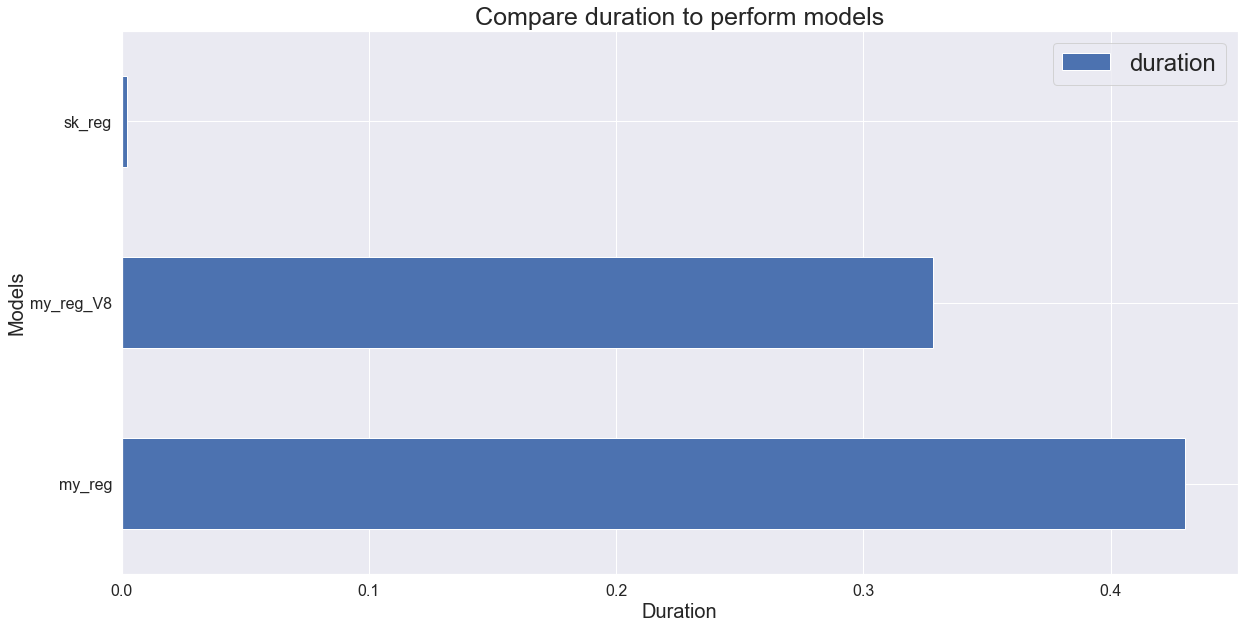

In [87]:
# Plot duration dependencies to model
plt.rcParams["figure.figsize"] = (20,10)
plt.size = 15
ax = fmri.reset_index().plot(kind="barh", 
                        x='index', 
                        y='duration',
                        title="Compare duration to perform models"
                       );

ax.set_ylabel('Models', fontsize=20);
ax.set_xlabel('Duration', fontsize=20);
plt.tick_params(axis='both', which='major', labelsize=16);
plt.legend( prop={'size': 24});
plt.title(label="Compare duration to perform models", fontsize=25);

In [88]:
# I implement pool optimisation from library multiprocessing for .predict from TreeRegressorV8,
# and implemetation Parallel from joblib in _find_best_split to TreeRegressorV8.
# This feature give speed perform for this model.
score["Task_9"] = 3

---

In [89]:
for task in score.keys():
    print(f"{task}: {score[task]}")
print("============")
print("TOTAL SCORE: ", sum(list(score.values())))
print("Score input in RS App:", sum(list(score.values())) * 10)

Task_1: 0.5
Task_2: 2
Task_3: 1
Task_4: 1
Task_5: 0.5
Task_6: 1
Task_7: 2
Task_8: 2
Task_9: 3
TOTAL SCORE:  13.0
Score input in RS App: 130.0
